# Discrete Quantum Walks with Classiq

The classical discrete random walk on a graph $G$ begins at a starting node $s$ and explores $G$ by randomly 'walking' one edge at a time. A discrete quantum walk makes use of superposition to explore all possible paths from $s$ at the same time, thus providing a general quantum path-searching framework that can offer exponential speedup to many NP-hard graph traversal problems.

A full mathematical description of a discrete quantum walk can be found in chapter 17 of Andrew Childs' [2022 University of Marlyand quantum algorithms lecture notes](https://www.cs.umd.edu/~amchilds/qa/qa.pdf#page=85). We will demonstrate how to implement a discrete quantum walk on any graph using the Classiq platform.

## Classical Formulation
Suppose we have a directed graph $G=(V,E)$ with $n$ nodes $v\in V$ having at most $n(n-1)$ directed edges $e\in E$, with no self-loops.  

To encode edge transition probabilities, we can use an $n\times n$ matrix $M$ with an entry $M_{kj}$ corresponding to the transition probability from node $j$ (column) to node $k$ (row). We can then express a probability distribution over all the nodes as an $n$-length vector $p$, where $Mp$ performs one step of the quantum walk to the next state $p'$. To ensure no probability is lost, the columns of $M$ must be normalized: $\forall j,\ \sum_k M_{kj} = 1$. In the case where all edges are equally likely to be traversed, 
$$M_{kj}= \begin{cases} 1/\text{deg}(j) & (j,k)\in E \\ 0 & \text{otherwise} \end{cases} $$

For this notebook, we will use an extremely simple graph topology as a demonstration: 16 nodes in a line forming a "rope", with equal edge weightings. Let's import everything we'll need as well.

graph with 16 nodes must use 4 qubits
0 -> 1 ... 1 -> 0, 2 ... 2 -> 1, 3 ... 3 -> 2, 4 ... 4 -> 3, 5 ... 5 -> 4, 6 ... 6 -> 5, 7 ... 7 -> 6, 8
8 -> 7, 9 ... 9 -> 8, 10 ... 10 -> 9, 11 ... 11 -> 10, 12 ... 12 -> 11, 13 ... 13 -> 12, 14 ... 14 -> 13, 15 ... 15 -> 14



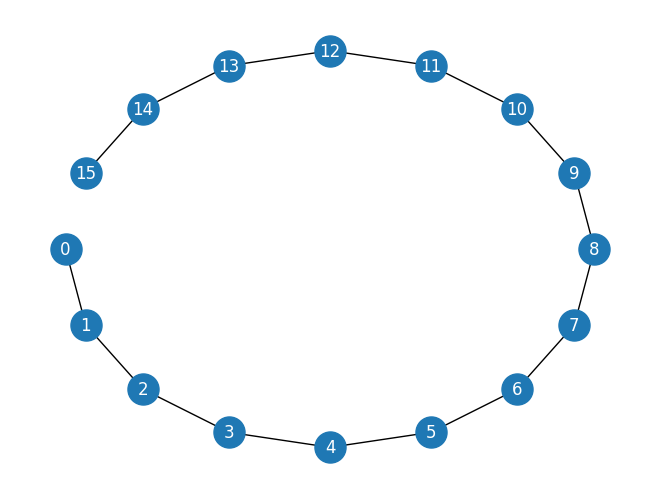

In [143]:
import numpy as np
np.set_printoptions(precision=3)
import networkx as nx
import matplotlib.pyplot as plt
from classiq import (
    qfunc, Output, QBit, QNum, QArray, CInt,
    allocate, within_apply, control, repeat, if_, 
    inplace_prepare_state, hadamard_transform, inplace_prepare_int, 
    create_model, synthesize, execute, write_qmod, show,
    X, H, SWAP, 
    set_constraints, Constraints, set_execution_preferences, set_preferences, Preferences, QuantumProgram, 
)
from classiq.execution import ExecutionPreferences

# create and draw the graph
size = 16
nqubits = int(np.ceil(np.log2(size)))
print(f"graph with {size} nodes must use {nqubits} qubits")
G = nx.path_graph(size)
nx.draw_shell(G, with_labels=True, node_size=500, font_size=12, font_color='white')

# get transition probabilities from graph
def transitions_list(G: nx.Graph | nx.DiGraph) -> list[list[float]]:
    """ 
    returns: probabilities[i] = list of transition probabilities for i
             probabilities[i][j] = probability of transitioning from i to j
     - graph can be either undirected or directed
     - if edges are unweighted, assume equal transition probabilities 
    """
    size = G.number_of_nodes()
    nqubits = int(np.ceil(np.log2(size)))
    # in practice, we must 
    M = np.zeros((2**nqubits, 2**nqubits))
    for e, data in G.edges.items():
        if isinstance(G, nx.DiGraph):
            M[e[0], e[1]] = data.get('weight', 1)
        else:
            M[e[0], e[1]] = data.get('weight', 1)
            M[e[1], e[0]] = data.get('weight', 1)
    # normalize columns
    for i in range(size):
        M[:, i] /= np.sum(M[:, i])
    transitions = [list(M[:,i]) for i in range(M.shape[0])]
    return transitions

# print transition probabilities, with equal weightings assumed
def print_transitions(probabilities: list[list[float]]):
    nodes_per_line = 8
    ret = []
    for i, p in enumerate(probabilities):
        idxs = []
        for j, q in enumerate(p):
            if q > 0:
                idxs.append(j)
        ret.append(f"{i} -> "+', '.join(map(str, idxs)))
    return "\n".join([" ... ".join(ret[i*nodes_per_line:(i+1)*nodes_per_line]) for i in range(len(ret)//nodes_per_line+1)])

probabilities = transitions_list(G)
print(print_transitions(probabilities))


## Quantum Formulation

To turn this quantum, we need to find a unitary $U$ that evolves an input node $|j\rangle$, for $j\in V$, to a superposition of its neighbors $|\partial_j\rangle$, where
$$|\partial_j\rangle = \sum_k \sqrt{M_{kj}}|k\rangle.$$

However, this operation isn't unitary, because orthogonal states $|j\rangle$, $|k\rangle$ can evolve to the same state $|l\rangle$, so we must enlarge the Hilbert space. This can be done by encoding all possible *directed edges* $(j,k)\in E$ as states $|j,k\rangle$ to represent the walker moving from vertex $j$ to vertex $k$, which means using twice the number of qubits than if we were just encoding nodes.


To perform one step of a quantum walk requires two unitary operations:
1. A "coin flip" operator $C$ that distributes the walker's destination into a superposition of possible destination edges
2. A swap operator $S$, which moves the walker from one edge to another

## Coin Flip Operator

This operator takes in an input edge $|j,k\rangle$ and prepares a superposition of all of the edges leaving $j$, 
$$|\psi_j\rangle=|j\rangle \otimes |\partial_j\rangle = |j\rangle \otimes \sum_k \sqrt{M_{kj}}|k\rangle = \sum_k \sqrt{M_{kj}}|j,k\rangle.$$

A common choice of this operator is the Grover diffusion operator:
$$C = \sum_j |j\rangle \langle j | \otimes \left(2|\partial_j\rangle\langle\partial_j | - I\right).$$

We can see that $C$ only changes the destination of the walker, contingent on the origin node $j$. 
If we have access to $\hat{U}_j|0\rangle = |\partial_j\rangle$, then $2|\partial_j\rangle\langle \partial_j|-I=\hat{U}_j(2|0\rangle\langle 0|-1)\hat{U}_j^\dag$, and we can re-express

$$C = \sum_j |j\rangle \langle j | \otimes \hat{U}_j \left(2|0\rangle\langle0 | - 1\right)\hat{U}_j^\dag .$$

$(2|0\rangle\langle0|-1)|x\rangle$ is $|x\rangle$ if $x=0$ and $-|x\rangle$ if $x\neq 0$. This function is known as the *zero diffuser*, which applies a negative phase to any non-zero states, and is implemented below:

In [131]:
@qfunc
def prepare_minus(aux: QBit):
    """ |0> to (|0> - |1>)/sqrt(2) """
    X(aux)
    H(aux)

@qfunc
def diffuser_oracle(aux: QBit, x: QNum):
    """ aux is set to |1> if x is not |0> """
    aux ^= (x != 0)

@qfunc
def zero_diffuser(x: QNum):
    """ (2|0><0| - I)|x> = |0> if x=0 else -|x>"""
    aux = QBit('aux')
    allocate(1, aux)
    within_apply(compute=lambda: prepare_minus(aux),
                 action=lambda:  diffuser_oracle(aux, x))

To complete the coin flip operator, we need `within-apply` to surround the zero diffuser with $\hat{U}_j$, which creates a superposition of all connected edges $|\psi_j\rangle$. To target a single node $j$ we use `control`, and repeat this for all nodes $j$ in a for loop. 

In [144]:
@qfunc 
def coin_flip(vertices: QNum, adjacent_vertices: QNum):
    """ apply diffusion operator to all nodes to superpose available edges
    - probabilites[i] must be a list of probabilities to move from i to j """
    for i in range(size):
        control(ctrl=(vertices == i),
            operand=lambda: within_apply(
                compute=lambda: inplace_prepare_state(probabilities[i], bound=0.01, target=adjacent_vertices),
                action=lambda: zero_diffuser(adjacent_vertices)))

To see how the coin flip operator changes the edge $|j,x\rangle$, we first note
$$|\partial_j\rangle\langle \partial_j| = \sum_{k} \sqrt{M_{kj}}|k\rangle \sum_{k'} \sqrt{M_{k'j}}\langle k'| = \sum_{k',k}\sqrt{M_{k'j}M_{kj}} |k'\rangle\langle k |,$$
and see that when the edges are traversed equally, $C$ changes the destination as
$$\begin{aligned}
(\langle j|\otimes I) C|j,x\rangle &= \left(2|\partial_j\rangle\langle \partial_j | - I\right)|x\rangle 
\\ &= 2\left(\sum_{k',k}\sqrt{M_{k'j}M_{kj}} |k\rangle\langle k'|\right)|x\rangle - |x\rangle
\\ &= 2\sqrt{M_{xj}}\sum_{k}\sqrt{M_{kj}}|k\rangle - |x\rangle
\\ &= 2\sqrt{M_{xj}}\sum_{k\neq x}\sqrt{M_{kj}}|k\rangle + \left(2M_{xj}-1\right)|x\rangle.
\end{aligned}$$

When all edges of the graph are unweighted,
$$\begin{aligned}
(\langle j|\otimes I) C|j,x\rangle &= \frac{2}{\text{deg}(j)}\sum_{k\neq x}|k\rangle + \frac{2-\text{deg}(j)}{\text{deg}(j)}|x\rangle.
\end{aligned}$$

We can see that we generate a superposition of all destinations $|k\rangle$ connected to $j$, weighted by the square root of the probability $M_{xj}M_{kj}$ that we end up at both $k$ and $x$ from $j$. The old destination $|x\rangle$ gets a special negative coefficient that encodes a phase of $\pi$, providing a small amount of destructive interference from travelling back in the same direction as before. The coin flip only works if $|j,x\rangle$ is a valid edge in the graph, where $M_{xj}\neq 0$, or else $C|x\rangle = -|x\rangle$.



## Swap Operator

To actually take a step along the graph, we want to move from node $j$ to node $k$ by moving from edge $|j,k\rangle$ to edge $|k,j\rangle$. The only way to do this unitarily is to *swap* the two edges and also move from $|k,j\rangle\to |j,k\rangle$. The swap operator swaps the second register with the first register: 

$$S = \sum_{j,k} |k,j\rangle \langle j,k|.$$

In [133]:
@qfunc 
def bitwise_swap(x: QArray[QBit], y: QArray[QBit]):
    """ global swap operation on two equally-sized quantum registers """
    repeat(count= x.len,
           iteration= lambda i: SWAP(x[i],y[i]))

We can also directly specify that $|k,j\rangle$ should be an edge that actually exists by using an *edge oracle*, which only swaps an edge after querying that it exists. This allows us to measure an auxillary qubit to see what percentage of edges any step in the walk is on, but increases the complexity of the circuit. This "targeted" swap operation could be useful when unused edges are being used to store more information in the circuit. With extremely simple graph structures, we can formulate the oracle simply, such as for a line:

In [134]:
@qfunc
def line_edge_oracle(res: Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    res |= ((vertices - adjacent_vertices == 1) | (vertices - adjacent_vertices == -1))

@qfunc 
def swap_operator(vertices: QNum, adjacent_vertices: QNum):
    res = QBit('res')
    line_edge_oracle(res, vertices, adjacent_vertices)
    control(ctrl=(res==1),
            operand=lambda: bitwise_swap(vertices, adjacent_vertices))

## Combining it all together

A single step of the quantum walk is performed by applying $C$ followed by $S$. If we start in the state $|x,y\rangle$, after one step we evolve to the state
$$\begin{aligned}
SC|x,y\rangle &= S\left(|x\rangle \otimes \left[2\sqrt{M_{yx}}\sum_{k\neq y}\sqrt{M_{kx}}|k\rangle + \left(2M_{yx}-1\right)|y\rangle \right]\right)
\\ &= 2\sqrt{M_{yx}}\sum_{k\neq y}\sqrt{M_{kx}}|k,x\rangle + \left(2M_{yx}-1\right)|y,x\rangle.
\end{aligned}$$

When the graph is unweighted, any $\deg(x)=1$ node evolves from $|x,y\rangle \to |y,x\rangle$, and any $\deg(x)=2$ node evolves from $|x,y\rangle$ to $|y',x\rangle$ for the new destination $y'$.

Before we start walking, we must initialize our starting state $|j_0,k_0\rangle$. In practice, we may want to start in a superposition of all available nodes. The best way to do this is to add an auxillary "starting" node to the graph that is directed to all nodes that you would like to start at, but no other node is directed to it. If we label this node $|0\rangle$, we can initialize a superposition of destination states using `hadamard_transform(adjacent_vertices)`. We only have to add a single row in the `probabilities` list that maps states from $|0\rangle$ to other nodes and insert a 0 before all of the other rows.

For the purpose of this demo, we will start in the $|0,1\rangle$ edge and demonstrate that after 15 steps we correctly end up at the $|15,14\rangle$ edge. After 30 steps, we should be back in the $|0,1\rangle$ edge. We enclose the entire Classiq running process within a regular Python function so that we can walk an arbitrary number of steps.

In [145]:
import time

# we use the simpler global swap operation to reduce complexity
@qfunc
def quantum_step(vertices: QNum, adjacent_vertices: QNum):
    coin_flip(vertices, adjacent_vertices)
    bitwise_swap(vertices, adjacent_vertices)

nsteps = 1
start = (3,2)
@qfunc
def main(vertices: Output[QNum], adjacent_vertices: Output[QNum]):
    allocate(nqubits, vertices)
    allocate(nqubits, adjacent_vertices)
    # we need to start on a valid edge of the graph, or else 
    # we will travel nowhere. start at |0,1>
    inplace_prepare_int(start[0], vertices)
    inplace_prepare_int(start[1], adjacent_vertices)
    for i in range(nsteps):
        quantum_step(vertices, adjacent_vertices)
    
qmod = create_model(main)
# path to store .qmod files, comment out if you don't want to store the .qmod code
write_qmod(qmod, f'qmod/qwalk-{nsteps}')

We can see a compiled version of this circuit below, which uses 25 qubits. `adjacent_vertices` is initialized on the first 4 qubits and `vertices` is initialized on the second 4 qubits, with all 17 other qubits used as auxillary qubits to implement the coin flip operation. The coin flip operation is so complex (using 2451 gates here) that performing 2 steps of a quantum walk increases the width of the circuit to 41 qubits, far outside of the classical simulation range. 

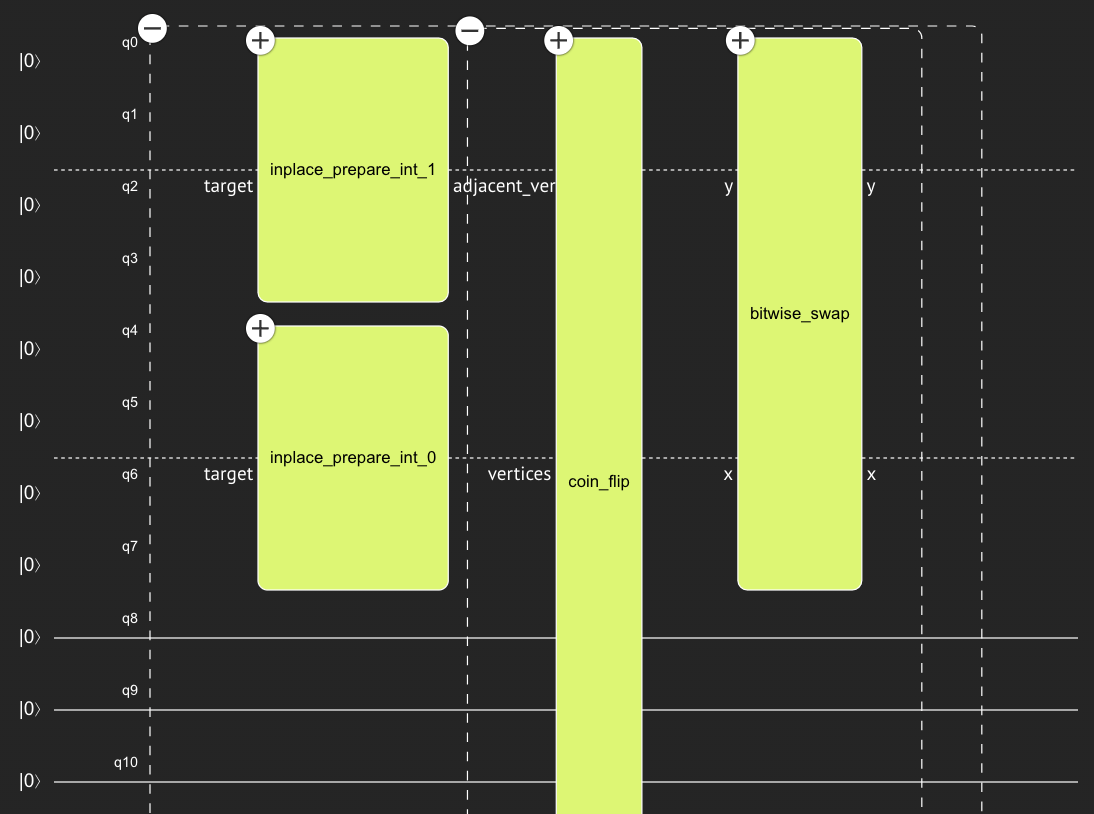

In [136]:
from IPython.display import Image
Image("1step_walk_from_32.png")

Below is the full Classiq implementation of a variable-length quantum walk starting from a single edge, that works on any graph as long as `probabilities` is correctly encoded into the coin flip. We can apply a variety of preferences to the circuit before we `synthesize` it, which takes about 140 seconds. After synthesis, we `execute` the quantum program with classiq and return the parsed states after execution.

In [146]:
def quantum_walk(nsteps: int, start_state: tuple[int, int] = (0, 1), num_shots = 50, show_circuit = False) -> dict:
    @qfunc
    def main(vertices: Output[QNum], adjacent_vertices: Output[QNum]):
        allocate(nqubits, vertices)
        allocate(nqubits, adjacent_vertices)
        # we need to start on a valid edge of the graph, or else 
        # we will travel nowhere. start at |0,1>
        inplace_prepare_int(start_state[0], vertices)
        inplace_prepare_int(start_state[1], adjacent_vertices)
        for i in range(nsteps):
            quantum_step(vertices, adjacent_vertices)
    
    qmod = create_model(main)
    # directory to store .qmod files, comment out if you don't want to store the .qmod code
    write_qmod(qmod, f'qmod/qwalk-{nsteps}')
    qmod = set_constraints(qmod, 
        Constraints(max_width=25, optimization_parameter='depth'))
    qmod = set_execution_preferences(qmod, 
        ExecutionPreferences(num_shots=num_shots, job_name=f"{nsteps}-step walk", random_seed='767'))
    qmod = set_preferences(qmod, 
        Preferences(backend_service_provider="Classiq", backend_name="simulator", 
                    timeout_seconds=600, optimization_timeout_seconds=120))
    print(f'synthesizing state |{start_state[0]},{start_state[1]}>')
    start_time = time.time()
    qprog = synthesize(qmod)
    circuit_width = QuantumProgram.from_qprog(qprog).data.width
    circuit_depth = QuantumProgram.from_qprog(qprog).transpiled_circuit.depth
    end_time = time.time()
    print(f"\ttook {end_time-start_time:.2f}s: width={circuit_width},depth={circuit_depth}")
    # open in viewer
    if show_circuit: show(qprog)
    start_time = time.time()
    job = execute(qprog)
    print(
        f"\tjob with {job.num_shots} shots is {job.status} on provider-backend={job.provider}-{job.backend_name} \n\tand can be accessed at {job.ide_url}"
    )
    results = job.result()[0].value
    end_time = time.time()
    print(f"\tjob took {end_time-start_time:.2f}s")
    return results.parsed_states

Because the coin flip operator must encode all relevant transition probabilities, performing more than one step in a row takes many qubits to do. This results in the synthesis engine producing a minimum width of 41 instead of 25. The following code performs the walk one step at a time. It took about two minutes to synthesize the code for each step. I ran this on various edges, and saw correct movement from $|0,1\rangle\to|1,0\rangle \to |2,1\rangle \to |3,2\rangle$. Interestingly, I reran this multiple times and found that $|3,2\rangle \to |6,3\rangle$, and nodes 4 and 5 seem disconnected from the graph. 

In [ ]:
def parsed_state_to_edge(parsed_state: dict) -> str:
    def index(v: dict) -> str:
        return f"|{int(v['vertices'])},{int(v['adjacent_vertices'])}>"
    return ' + '.join([index(v) for v in parsed_state.values()])

for state in [(0,1),(3,2),(3,4),(5,4),(4,5),(15,14)]:
    parsed_states = quantum_walk(1, state)
    print(f"|{state[0]},{state[1]}> -> "+parsed_state_to_edge(parsed_states))